<function matplotlib.pyplot.show(close=None, block=None)>

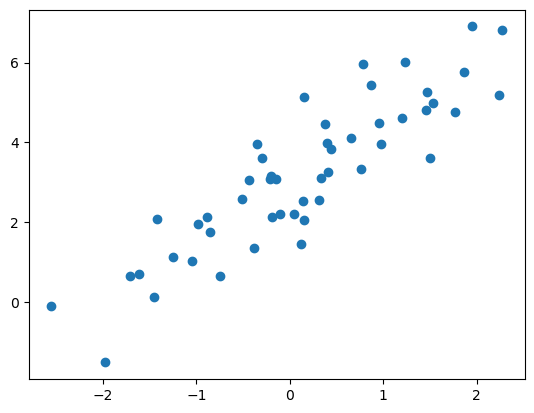

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(0)
m = 50
X = np.random.randn(m).reshape(-1, 1)
y = 1.5*X + 3 + np.random.randn(m).reshape( - 1 , 1)

plt.scatter(X, y)
plt.show



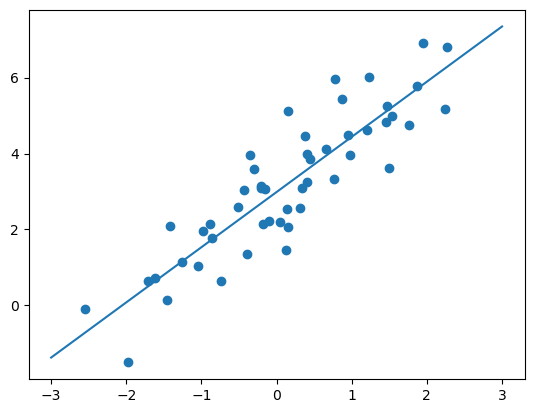

In [6]:
model = LinearRegression()
model.fit(X, y)

new_data = np.linspace(-3, 3).reshape(-1, 1)
predictions = model.predict(new_data)

plt.scatter(X, y)
plt.plot(new_data, predictions)
plt.show()